In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import librosa
import os
import soundfile as sf
import torch, torchaudio
import torchaudio.functional as f
import re
from scipy.signal import resample
from sklearn.metrics import accuracy_score

# Loading Dataset

In [3]:
dir = './recordings/'
audio_list = os.listdir(dir)

# Pre-Processing

## Extracting MFCC

In [5]:
target_sample_rate = 44100

def extract_features(audio_file, n_fft=128, hop_length=32, n_mfcc=13):
    y, sr = sf.read(audio_file)
    
    # Check if sample rate is the same
    if sr != target_sample_rate:
        y = resample(y, int(len(y) * target_sample_rate / sr))
        sr = target_sample_rate 
        
    # Extract first 10 seconds of audio
    samples_10_sec = target_sample_rate * 10   
    y_10_sec = y[:samples_10_sec]

    # Extract MFCC
    mfccs = librosa.feature.mfcc(y = y_10_sec, sr=sr, n_mfcc=n_mfcc)
    
    # Normalize MFCCs
    mfccs_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)

    return mfccs

In [6]:
data = []
for audio in audio_list:
    audio_path = dir + "/" + audio

    feature = extract_features(audio_path)    
    label = re.sub(r'\d+', '', audio[:-4])

    data.append((feature, label))

## Converting to DataFrame

In [7]:
seperated_data =[]
label_arr = []
for f,l in data:
    mfcc_dict = {f'MFCC_{i+1}': np.mean(f[i]) for i in range(f.shape[0])}
    label_arr.append(l)
    seperated_data.append(mfcc_dict)

In [8]:
df_new = pd.DataFrame(seperated_data)
df_new['label'] = label_arr
df_new.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label
0,-311.744874,114.093185,8.998494,31.688650,20.317011,9.907870,-10.170405,2.250550,-5.617399,-2.327972,0.056130,-12.694043,-1.135773,afrikaans
1,-299.748740,115.385810,-9.600186,43.880045,13.778640,28.913742,-3.845053,6.881457,-3.049777,-8.422302,-4.183617,-6.750145,-4.890782,afrikaans
2,-348.520993,127.671517,4.990566,33.457645,22.580974,10.990127,2.758346,-6.828801,-7.585002,-20.160269,-22.072912,-8.224914,-0.495822,afrikaans
3,-289.374186,127.725709,3.630723,41.737425,21.228604,10.654472,10.353205,0.754413,-12.247970,1.253995,-1.261070,-1.139724,-10.082326,afrikaans
4,-367.997361,135.368703,2.400631,30.805342,-12.364562,17.189769,0.563212,7.612488,5.399307,-7.191656,2.022258,-4.139912,-0.492867,afrikaans


In [9]:
df_new.isnull().sum()

MFCC_1     0
MFCC_2     0
MFCC_3     0
MFCC_4     0
MFCC_5     0
MFCC_6     0
MFCC_7     0
MFCC_8     0
MFCC_9     0
MFCC_10    0
MFCC_11    0
MFCC_12    0
MFCC_13    0
label      0
dtype: int64

In [10]:
print(len(df_new))
df_cleaned = df_new.dropna()
print(len(df_cleaned))

2138
2138


In [11]:
accent_counts = df_cleaned['label'].value_counts()
print(accent_counts)

label
english        579
spanish        162
arabic         102
mandarin        65
french          63
              ... 
nandi            1
nama             1
mortlockese      1
moore            1
zulu             1
Name: count, Length: 200, dtype: int64


## Oversampling Dataset

In [12]:
largest_accent = accent_counts.idxmax()
max_count = accent_counts.max()

# Oversample smaller accent groups to match the size of the largest group but take the ones with more than 30 audio files
oversampled_data = []
for accent, count in accent_counts.items():
    if accent != largest_accent and count > 30:
        accent_data = df_cleaned[df_cleaned['label'] == accent]
        oversampled_accent = accent_data.sample(n=max_count, replace=True, random_state=42)
        oversampled_data.append(oversampled_accent)
    elif accent == largest_accent:
        oversampled_data.append(df_cleaned[df_cleaned['label'] == accent])


balanced_df = pd.concat(oversampled_data)

In [13]:
# handle undersampling kl native / non native
# native = df_cleaned[df_cleaned['label'] == 'native']
# oversampled_native = native.sample(n=1559, replace=True, random_state=42)
# smallest = df_cleaned[df_cleaned['label'] == 'non-native']

# df_balanced = pd.concat([oversampled_native[:len(smallest)], smallest]).reset_index(drop=True)
# df_balanced.head()

In [14]:
# handle undersampling kl bbrp accent doang
# biggest = df_cleaned[df_cleaned['label'] == 'english']

# spanish = df_cleaned[df_cleaned['label'] == 'spanish']
# oversampled_spanish = spanish.sample(n=579, replace=True, random_state=42)
# arabic = df_cleaned[df_cleaned['label'] == 'arabic']
# oversampled_arabic = arabic.sample(n=579, replace=True, random_state=42)

# df_balanced = pd.concat([biggest, oversampled_spanish, oversampled_arabic]).reset_index(drop=True)
# print(Counter(df_balanced['label']))
# df_balanced.head()

In [15]:
df_shuffled = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,MFCC_11,MFCC_12,MFCC_13,label
0,-342.921301,143.915295,-9.081828,28.365973,19.592566,-6.840230,10.383843,-9.405227,-13.860366,1.156899,-8.724627,-7.937325,-5.631774,german
1,-350.677259,89.848135,-10.941949,21.775786,-8.119773,3.956101,-10.808382,-4.364986,-9.709041,-4.550846,-10.766002,-6.412988,-8.990570,arabic
2,-329.246617,82.190002,-27.423848,31.517208,0.128355,11.080160,-14.790817,16.444887,-17.718327,1.399003,-0.906294,0.915481,-1.433161,korean
3,-321.883146,129.941286,10.908632,49.641281,0.622678,25.685203,-6.772427,4.938980,4.410233,-0.982691,-3.390297,-8.540936,-6.124738,turkish
4,-335.152471,95.903616,-0.727520,36.248681,2.543216,21.997761,-2.040537,11.246912,2.103970,-2.947939,-4.053631,11.449569,-1.172365,portuguese


In [16]:
# Seperating Data to x and y
y = df_shuffled["label"]
x = df_shuffled.drop('label', axis = 1)

## Encoding Label (From Categorial to Numerical)

In [17]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y)

label_mapping = {label: encoded_label for label, encoded_label in zip(y, encoded_labels)}

# Print the mapping
class_label = []
print("Label mapping:")
for label, encoded_label in label_mapping.items():
    class_label.append(label)
    print(f"{label}: {encoded_label}")

Label mapping:
german: 4
arabic: 0
korean: 6
turkish: 12
portuguese: 9
russian: 10
english: 2
mandarin: 7
dutch: 1
spanish: 11
polish: 8
french: 3
italian: 5


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Training with Machine Learning Model

## KNN

In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_accuracy = knn.score(x_test, y_test)
knn_accuracy

0.897078353253652

In [20]:
y_train_pred_knn = knn.predict(x_train)
train_accuracy_knn = accuracy_score(y_train, y_train_pred_knn)
test_accuracy_knn = accuracy_score(y_test, knn_pred)

print("Training Accuracy: ", train_accuracy_knn)
print("Testing Accuracy: ", test_accuracy_knn)

Training Accuracy:  0.9269224381332004
Testing Accuracy:  0.897078353253652


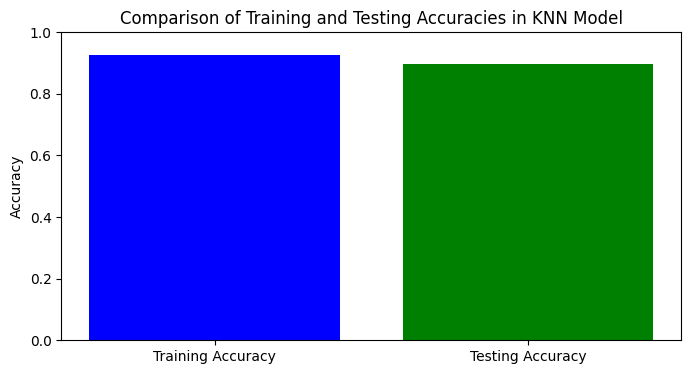

In [21]:
accuracies = [train_accuracy_knn, test_accuracy_knn]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in KNN Model')
plt.ylim([0, 1]) 
plt.show()

## Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(x_train, y_train)
pred_dt = dt.predict(x_test)
dt_accuracy = dt.score(x_test, y_test)
dt_accuracy

0.952191235059761

In [23]:
y_train_pred_dt = dt.predict(x_train)
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, pred_dt)

print("Training Accuracy: ", train_accuracy_dt)
print("Testing Accuracy: ", test_accuracy_dt)

Training Accuracy:  1.0
Testing Accuracy:  0.952191235059761


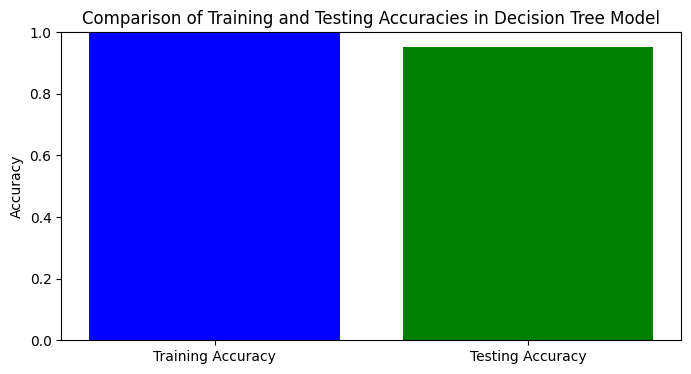

In [24]:
accuracies = [train_accuracy_dt, test_accuracy_dt]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in Decision Tree Model')
plt.ylim([0, 1]) 
plt.show()

## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
randf = RandomForestClassifier(random_state = 42)
randf.fit(x_train, y_train)
pred_randf = randf.predict(x_test)
randf_accuracy = randf.score(x_test, y_test)
randf_accuracy

0.9867197875166003

In [26]:
y_train_pred_rf = randf.predict(x_train)
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, pred_randf)

print("Training Accuracy: ", train_accuracy_rf)
print("Testing Accuracy: ", test_accuracy_rf)

Training Accuracy:  1.0
Testing Accuracy:  0.9867197875166003


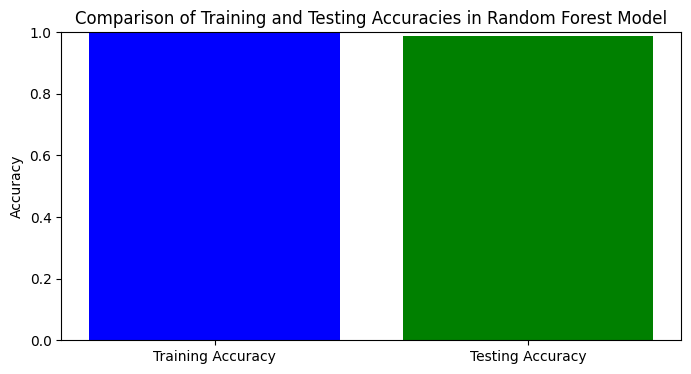

In [27]:
accuracies = [train_accuracy_rf, test_accuracy_rf]

plt.figure(figsize=(8, 4))
plt.bar(['Training Accuracy', 'Testing Accuracy'], accuracies, color=['blue', 'green'])
plt.ylabel('Accuracy')
plt.title('Comparison of Training and Testing Accuracies in Random Forest Model')
plt.ylim([0, 1]) 
plt.show()

In [29]:
import joblib as jb
# save models
jb.dump(knn, 'knn_model_10.joblib')
jb.dump(dt, 'dt_model_10.joblib')
jb.dump(randf, 'randf_model_10.joblib')

['randf_model_10.joblib']

In [28]:
# # load models
# knn_default = jb.load('knn.joblib')
# dt_default = jb.load('dt.joblib')
# randf_default = jb.load('randf.joblib')

In [30]:
from sklearn.metrics import classification_report
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

      arabic       0.90      0.87      0.88       141
       dutch       0.89      1.00      0.94       119
     english       0.79      0.10      0.18       107
      french       0.85      0.97      0.91       107
      german       0.91      1.00      0.95       114
     italian       0.92      1.00      0.96       119
      korean       0.90      0.98      0.94       111
    mandarin       0.90      0.96      0.93       124
      polish       0.95      1.00      0.97       109
  portuguese       0.92      1.00      0.96       110
     russian       0.87      1.00      0.93       104
     spanish       0.83      0.76      0.79       124
     turkish       0.92      1.00      0.96       117

    accuracy                           0.90      1506
   macro avg       0.89      0.90      0.87      1506
weighted avg       0.89      0.90      0.87      1506



In [31]:
print(classification_report(y_test, pred_dt))

              precision    recall  f1-score   support

      arabic       0.97      1.00      0.98       141
       dutch       0.97      1.00      0.98       119
     english       0.95      0.36      0.53       107
      french       0.94      1.00      0.97       107
      german       0.95      1.00      0.97       114
     italian       0.98      1.00      0.99       119
      korean       0.93      1.00      0.97       111
    mandarin       0.97      1.00      0.98       124
      polish       0.98      1.00      0.99       109
  portuguese       0.96      1.00      0.98       110
     russian       0.94      1.00      0.97       104
     spanish       0.89      0.97      0.93       124
     turkish       0.97      1.00      0.98       117

    accuracy                           0.95      1506
   macro avg       0.95      0.95      0.94      1506
weighted avg       0.95      0.95      0.94      1506



In [32]:
print(classification_report(y_test, pred_randf))

              precision    recall  f1-score   support

      arabic       0.97      1.00      0.99       141
       dutch       0.98      1.00      0.99       119
     english       0.95      0.87      0.91       107
      french       1.00      0.99      1.00       107
      german       1.00      1.00      1.00       114
     italian       0.99      1.00      1.00       119
      korean       1.00      1.00      1.00       111
    mandarin       0.99      1.00      1.00       124
      polish       0.99      1.00      1.00       109
  portuguese       1.00      1.00      1.00       110
     russian       1.00      1.00      1.00       104
     spanish       0.96      0.96      0.96       124
     turkish       1.00      1.00      1.00       117

    accuracy                           0.99      1506
   macro avg       0.99      0.99      0.99      1506
weighted avg       0.99      0.99      0.99      1506

